In [ ]:
import os
import sys
import time as t_util
import numpy as np
import pandas as pd
import cftime
import xarray as xr
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import yaml


In [ ]:
#Read main path
with open('../path_main.txt', 'r') as file:    path_main  = file.read()

dir_data_HSIchg = f'{path_main}Data/Plot_preparation/HSI_changes/'
dir_data_ThrExc = f'{path_main}Data/Plot_preparation/Threshold_Exceedance/'
dir_data_HWMId  = f'{path_main}Data/Plot_preparation/HWMId/'
dir_scripts     = f'{path_main}Scripts/'
dir_names       = f'{path_main}Scripts/Model_lists/'
dir_fig         = f'{path_main}Figures/Paper_v2/'
dir_repo        = f'{path_main}Data/RepositoryPublication/'
if not os.path.exists(dir_fig): os.mkdir(dir_fig)
    

## Prepare variables and parameters

In [ ]:
#Define cities
cities = ['Lisbon', 'Madrid', 'Barcelona', 'Rome', 'Athens', 'Istanbul', 'Sofia', 'Bucharest', 'Belgrade',
          'Zagreb', 'Milan', 'Budapest', 'Munich', 'Vienna', 'Prague', 'Paris', 'Brussels', 'Amsterdam',
          'London', 'Dublin', 'Hamburg', 'Copenhagen', 'Berlin', 'Warsaw', 'Kharkiv', 'Kyiv', 'Minsk','Vilnius', 
          'Riga', 'Moscow', 'NizhnyNovgorod', 'Kazan', 'SaintPetersburg', 'Helsinki', 'Stockholm', 'Oslo']

cities = np.array(cities)

#Define HSIs
HSIs = ['TX']
    
HSI_out = {'TN': 'TN', 
           'TX': 'TX'}

# Load city coordinates
fname_coords = dir_scripts + 'City_coordinates.yml'
with open(fname_coords, 'r') as file:
    city_coords = yaml.safe_load(file)
    
#Define scenarios and variables
RCP = 'rcp85'

#Define models and RCPs which should be used
all_models = dict()
all_models = []
with open(dir_names + 'Models_CORDEX-EUR-11_RCP85.txt', 'r') as filehandle:
    for line in filehandle:
        all_models.append(eval(line[:-1]))

#Define warming levels
EMT_change = '3.0K'#'1.0K', '2.0K', 


## Plot preparation

In [ ]:
#Titles 1
tit_chg = dict()
tit_chg['JJA_mean'] = ' (JJA mean)'
tit_chg['Q90']      = ' (JJA, Q90)'
tit_chg['Ymax']     = 'x change'

#Titles 2
titles = dict()
titles['HSI-changes'] = lambda HSI, THR_level : HSI +  tit_chg[t_method]
titles['Threshold-Exceedance'] = lambda HSI, THR_level: 'Exceedance ' + HSI + '>' + THR_levels_vals[HSI + '_' + THR_level] + '°C'
titles['HWMId'] = lambda HSI, THR_level :  'HWMId-' + HSI

#Units
units = dict()
units['HSI-changes'] = '°C'
units['Threshold-Exceedance'] = 'd/y'
units['HWMId'] = ''

#Color, scaling, and alpha
edgecolor = 'k'
sc_scale  = 200
sc_offset = 400
alpha     = 0.8

#Define ranking vector
ranks = np.arange(1, len(cities) + 1)

ranges = dict()
ranges['TN_3.0K'] = [[5, 10],
                    [10, 12],
                    [12, 15],
                    [15, 20],
                    [20, 30],
                    [30, np.inf]]

ranges['TX_3.0K'] = [[2,   4],
                    [4,  5],
                    [5, 6],
                    [6, 8],
                    [8, 12],
                    [12, np.inf]]

THR_levels = dict()
THR_levels['TN'] = 3 # 20 °C
THR_levels['TX'] = 3 # 30 °C

THR_levels_vals = dict()
THR_levels_vals['TN_Level3']      = '20'
THR_levels_vals['TX_Level3']      = '30'

vmax_all = dict()
vmax_all['TN']        = 120
vmax_all['TX']        = 120
vmax_all['TN-change'] = 5
vmax_all['TX-change'] = 5

#Define colormap
cmap   = matplotlib.cm.get_cmap('Reds', len(cities))
colors = cmap(np.linspace(0, 0.9,  len(cities)))


## Plot for EMT

In [ ]:
# out_name = '_3x3'
out_name = ''

#Select methods to show in plot
methods = ['HSI-changes', 'Threshold-Exceedance', 'HWMId']
texts   = ['a)', 'b)', 'c)']

#Select which time method to use for HSI changes ('JJA_mean', 'Q90', 'Ymax')
t_method = 'Ymax'

#Loop over HSIs
val_coll = dict()
for i6, HSI in enumerate(HSIs):

    #Create figure
    fig, axes = plt.subplots(3, 1, figsize=(12, 17), subplot_kw=dict(projection=ccrs.Robinson()))
    plt.subplots_adjust(hspace=0.6)
    

    #Read data for HSI change
    data_HSIchg = xr.open_dataset(dir_data_HSIchg + 'EURO-CORDEX' + out_name + '/HSIs-changes_rcp85_EMT.nc')
    models      = data_HSIchg.model
    data_HSIchg = data_HSIchg.sel(city=cities, EMT_change=EMT_change, t_method=t_method)[HSI]
    data_HSIchg_val = data_HSIchg.values

    #Read data for threshold exceedance
    THR_level = 'Level' + str(THR_levels[HSI])
    data_ThrExc = xr.open_dataset(dir_data_ThrExc + 'EURO-CORDEX' + out_name + '/HSIs-ThresholdExceedance_rcp85_EMT.nc')
    data_ThrExc = data_ThrExc.sel(city=cities, EMT_change=EMT_change, THR_level=THR_level, transformation='no_trans')[HSI]
    data_ThrExc_val = data_ThrExc.values

    #Read data for HWMId
    data_HWMId = xr.open_dataset(dir_data_HWMId + 'EURO-CORDEX' + out_name + '/HWMId' + '-' + HSI + '_' + RCP + '_EMT.nc')
    data_HWMId = data_HWMId.sel(city=cities, EMT_change=EMT_change, quantile='Q50').HWMID
    data_HWMId_val = data_HWMId.values

    #Save data in dict for plotting
    data_plot = dict()
    data_plot['HSI-changes']          = data_HSIchg
    data_plot['Threshold-Exceedance'] = data_ThrExc
    data_plot['HWMId']                = data_HWMId

    #Calculate ranking average across models
    data_HSIchg_val = np.median(data_HSIchg_val, axis=0)
    data_ThrExc_val = np.median(data_ThrExc_val, axis=0)
    data_HWMId_val  = np.median(data_HWMId_val, axis=0)            

    #Sort values
    data_HSIchg_val = np.argsort(data_HSIchg_val)
    data_ThrExc_val = np.argsort(data_ThrExc_val)
    data_HWMId_val  = np.argsort(data_HWMId_val)

    #Create empty arrays
    ranking_HSIchg = np.empty(data_HSIchg_val.shape) * np.NaN
    ranking_ThrExc = np.empty(data_ThrExc_val.shape) * np.NaN
    ranking_HWMId  = np.empty(data_HWMId_val.shape)  * np.NaN

    #Loop over models and get ranking of each city
    ranking_HSIchg[data_HSIchg_val] = ranks
    ranking_ThrExc[data_ThrExc_val] = ranks
    ranking_HWMId[data_HWMId_val]   = ranks

    #Order cities according to average ranking
    cities_ordered = dict()
    cities_ordered['HSI-changes']          = np.flip(cities[np.argsort(ranking_HSIchg)])
    cities_ordered['Threshold-Exceedance'] = np.flip(cities[np.argsort(ranking_ThrExc)])
    cities_ordered['HWMId']                = np.flip(cities[np.argsort(ranking_HWMId)])

    #Loop over methods
    for i5, method in enumerate(methods):

        ax = axes[i5]

        #Add coastlines and borders
        ax.coastlines(resolution='50m', linewidth=0.75, color='#737373', zorder=0)
        ax.add_feature(cfeature.LAND, facecolor='#f0f0f0')
        ax.add_feature(cfeature.OCEAN, facecolor='aliceblue')
        ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='#969696', zorder=0)
        ax.set_extent([-12, 45, 35, 62], crs=ccrs.PlateCarree())
        ax.spines['geo'].set_zorder(30)

        #Loop over cities
        x = [];  y = []
        for i0, city in enumerate(cities_ordered[method]):

            #Get coordinates
            coord = city_coords[city]

            #Write number
            if i0<5:
                ax.text(coord[1], coord[0], str(i0+1), transform=ccrs.PlateCarree(),
                        color='w', fontsize=10, fontweight='bold', ha='center', va='center')
            elif i0>len(cities_ordered[method]) - 6:
                ax.text(coord[1], coord[0], str(i0+1), transform=ccrs.PlateCarree(),
                        color='k', fontsize=10, ha='center', va='center')
                
            x.append(coord[1])
            y.append(coord[0])

        #Get multi-model median
        val = data_plot[method].median('model').sel(city=cities_ordered[method])

        if method=='HSI-changes':

            vmin = 2
            vmax = vmax_all[HSI + "-change"]

            #Scatter plot
            sc = ax.scatter(x, y, s=sc_scale*(val-vmin)/(vmax-vmin) + sc_offset, transform=ccrs.PlateCarree(),
                            color=cmap((val-vmin)/(vmax-vmin)), edgecolor=edgecolor, cmap=cmap, vmax=vmax, vmin=vmin, alpha=alpha)

            val_h = np.arange(vmin, vmax+1, 1)
            x_h = np.ones(len(val_h))
            y_h = np.ones(len(val_h))    
            for x, y, v in zip(x_h, y_h, val_h):

                sc_h = ax.scatter(x, y, s=sc_scale*(v-vmin)/(vmax-vmin) + sc_offset, transform=ccrs.PlateCarree(),
                                  color=cmap((v-vmin)/(vmax-vmin)), edgecolor=edgecolor, label=v, alpha=alpha)

            #Number of legend entries
            N_leg = len(val_h)

        elif method=='Threshold-Exceedance':

            vmin = 0
            vmax = vmax_all[HSI]

            #Scatter plot
            sc = ax.scatter(x, y, s=sc_scale*val/vmax + sc_offset, transform=ccrs.PlateCarree(), c=val, edgecolor=edgecolor,
                            cmap=cmap, vmax=vmax, vmin=vmin, alpha=alpha)

            val_h = np.arange(0, vmax+1, 30)
            x_h = np.ones(len(val_h))
            y_h = np.ones(len(val_h))    
            for x, y, v in zip(x_h, y_h, val_h):

                sc_h = ax.scatter(x, y, s=sc_scale*v/vmax + sc_offset, transform=ccrs.PlateCarree(), color=cmap(v/vmax),
                                  edgecolor=edgecolor, label=v, alpha=alpha)

            #Number of legend entries
            N_leg = len(val_h)

        elif method=='HWMId':

            x = np.array(x)
            y = np.array(y)


            N = len(ranges[HSI + '_' + EMT_change]) - 1
            for i4, rg in enumerate(ranges[HSI + '_' + EMT_change]):

                sel = (val>rg[0]) & (val<=rg[1])
                val_sel = i4 * np.ones(len(val[sel]))
                x_sel = x[sel.values]
                y_sel = y[sel.values]

                if i4==N:
                    label = '>' + str(rg[0])
                else:
                    label = str(rg[0]) + ' \u2014 ' + str(rg[1])

                sc = ax.scatter(x_sel, y_sel, s=sc_scale*val_sel/5 + sc_offset, color=cmap(i4/N), edgecolor=edgecolor,
                                transform=ccrs.PlateCarree(), alpha=alpha)

                sc_h = ax.scatter(0, 0, s=sc_scale*i4/5 + sc_offset, transform=ccrs.PlateCarree(), color=cmap(i4/N),
                                  edgecolor=edgecolor, label=label, alpha=alpha)


                #Number of legend entries
                N_leg = len(ranges[HSI + '_' + EMT_change])
                
        #Set title
        ax.set_title(titles[method](HSI, THR_level), fontsize=20, fontweight='bold', pad=20)

        #Prepare legend
        if N_leg>5:
            ncol = int(len(ranges[HSI + '_' + EMT_change])/2)
            y_bbox = -0.38
            y_txt  = -0.53
        else:
            ncol = N_leg
            y_bbox = -0.23
            y_txt  = -0.33
        if i5==1:
            columnspacing = 1.45
            handletextpad = 0.3
        else:
            columnspacing = 2
            handletextpad = 0.5
            
        #Legend
        legend = ax.legend(fontsize=17, bbox_to_anchor=(0.5, y_bbox), frameon=False, loc='lower center',
                           labelspacing=1, columnspacing=columnspacing, handletextpad=handletextpad, ncol=ncol)
        ax.text(0.5, y_txt, units[method], fontsize=24, va='bottom', ha='center', transform=ax.transAxes)

        #Collec values in dict
        val_coll[HSI +'_' + method] = val
    
        
        #Write letters
        ax.text(0.03, 0.96, texts[i5], fontsize=16, fontweight='bold', va='top', ha='left', transform=ax.transAxes)
        

    #Save figure
    if out_name=='' and HSI=='TX':  fig_name = 'Fig4_'
    else:                           fig_name = 'FigSx_'
    plt.savefig(dir_fig + fig_name + 'HeatStressMap_' + HSI + '_dEMT' + EMT_change + '_EURO-CORDEX' + out_name + '.png',
                bbox_inches='tight', dpi=300)


## Export data to excel

In [ ]:
#Define HSI and threshold level
HSI ='TX'
THR_level = 'Level' + str(THR_levels[HSI])

#Define units
units = dict()
units['HSI-changes'] = 'unit: K'
units['Threshold-Exceedance'] = 'unit: d/y'
units['HWMId'] ='unit: 1'

#Define output file name
fname_out = dir_repo + 'Data_Fig4_' + HSI + '-ambient-heat_EURO-CORDEX_DeltaESAT-3C.xlsx'
if os.path.exists(fname_out):  os.remove(fname_out)

#Create excel file
with pd.ExcelWriter(fname_out, mode="w") as writer:

    #Loop over methods
    for method in methods:

        #Get title
        name = titles[method](HSI, THR_level)
        
        #Select data
        data = data_plot[method].median('model')
        
        #Drop unnecessary coordinates
        coords_drop = [coord for coord in data.coords if coord!='city']
        data = data.drop(coords_drop)

        #Convert to data frame
        data = data.to_dataframe(name=name)

        #Sort cities alphabetically
        data = data.sort_index()
            
        #Add unit
        data.index = data.index.rename(units[method])
        data.columns = data.columns.rename('')

        #Save in file
        data.to_excel(writer, sheet_name=name, float_format="%.2f")


## Plot uncertainty

['Paris' 'Brussels' 'Amsterdam' 'Kyiv' 'Minsk' 'Moscow' 'SaintPetersburg']


NameError: name 'sdaf' is not defined

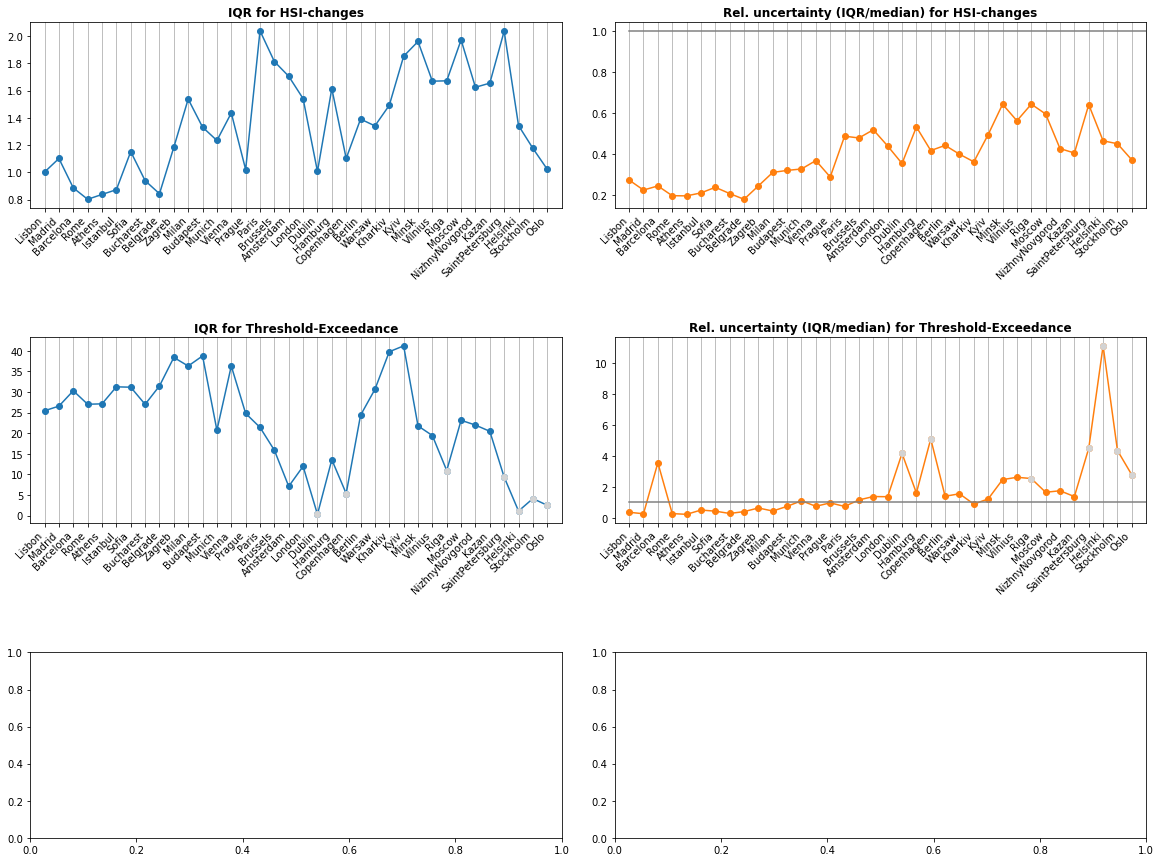

In [25]:
#Create figure
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
plt.subplots_adjust(hspace=0.7, wspace=0.1)

data_coll = dict()

#Loop over methods
for i0, method in enumerate(methods):
    
    ax1 = axes[i0, 0]
    ax2 = axes[i0, 1]
    
    #Set title
    ax1.set_title('IQR for ' + method, fontweight='bold')
    ax2.set_title('Rel. uncertainty (IQR/median) for ' + method, fontweight='bold')
    
    #Calculate IQR and median
    data_sel = data_plot[method]
    data_IQR = data_sel.quantile(0.75, dim='model') - data_sel.quantile(0.25, dim='model')
    data_med = data_sel.quantile(0.50, dim='model')
    
    data_coll[method + '_unc'] = data_IQR
    data_coll[method + '_unc_rel'] = data_IQR/data_med
    
    #Plot
    ax1.plot(data_IQR, '-o')
    ax2.plot(data_IQR/data_med, '-o', color='tab:orange')
    ax2.plot([0, 36], [1, 1], color='gray')
 
    if method=='Threshold-Exceedance':
        data_mask = data_med<5
        ax1.plot(data_IQR.where(data_mask), 'o', color='lightgray')
        ax2.plot(data_IQR/data_med.where(data_mask), 'o', color='lightgray')
        
    ax1.set_xticks(range(0, len(data_sel.city)))
    ax2.set_xticks(range(0, len(data_sel.city)))
    ax1.set_xticklabels(data_sel.city.values, rotation=45, ha='right')
    ax2.set_xticklabels(data_sel.city.values, rotation=45, ha='right')
    ax1.grid(axis = 'x')
    ax2.grid(axis = 'x')
    ax1.set_xlim([-1, len(data_sel.city)])
    ax2.set_xlim([-1, len(data_sel.city)])
    
    #Print values
    if method=='HSI-changes':
        print(data_IQR.where(data_IQR>1.7, drop=True).city.values)
    elif method=='HWMId':
        print(data_IQR.where(data_IQR>8, drop=True).city.values)
    else:
        sdaf

## Plot city ranking for each metric

In [ ]:
nums_coll = pd.DataFrame(index=cities, columns=methods, data=0)

for method in methods:
    for i0, city in enumerate(cities_ordered[method]):
        
        nums_coll.loc[city, method] = i0 + 1
        
#Create figure
fig, ax = plt.subplots(1, 1, figsize=(20, 5))

nums_coll.plot(ax=ax, marker='x', linestyle='none')


ax.set_xticks(range(0, len(data_sel.city)))
# ax2.set_xticks(range(0, len(data_sel.city)))
ax.set_xticklabels(data_sel.city.values, rotation=45, ha='right')
# ax2.set_xticklabels(data_sel.city.values, rotation=45, ha='right')
ax.grid(axis = 'x')
# ax2.grid(axis = 'x')
ax.set_xlim([-1, len(data_sel.city)])
# ax2.set_xlim([-1, len(data_sel.city)])

print((nums_coll.max(axis=1) - nums_coll.min(axis=1)).sort_values()[-10::])
print((nums_coll.std(axis=1)).sort_values()[-10::])
print((nums_coll.quantile(0.75, axis=1) - nums_coll.quantile(0.25, axis=1)).sort_values()[-10::])
